In [ ]:
import gymnasium as gym
from bettermdptools.envs.blackjack_wrapper import BlackjackWrapper
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.utils.grid_search import GridSearch
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.decorators import add_to
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Value Iteration

In [ ]:
RANDOM_SEED = 10

gammas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
n_iters = [10, 20, 50, 100, 200, 500, 1000]
theta = [0.1, 0.01, 0.001, 0.0001, 0.00001]
base_env = gym.make('Blackjack-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)

rewards_and_params_results_vi, highest_avg_reward_vi, best_params_vi = GridSearch.vi_grid_search(blackjack, gammas, n_iters, theta, verbose=False)
print(highest_avg_reward_vi, best_params_vi)

# Best params for VI
# random seed = 10 -> best_params_vi = {'gamma': 0.7, 'n_iter': 20, 'theta': 0.1}, highest_avg_reward_vi = 0.25
# random seed = 20 -> best_params_vi = {'gamma': 0.94, 'n_iter': 1000, 'theta': 0.0001}, highest_avg_reward_vi = 0.22
# random seed = 30 -> best_params_vi = {'gamma': 0.98, 'n_iter': 10, 'theta': 0.001}, highest_avg_reward_vi = 0.2
# random seed = 40 -> best_params_vi = {'gamma': 0.9, 'n_iter': 20, 'theta': 0.01}, highest_avg_reward_vi = 0.2
# random seed = 50 -> best_params_vi = {'gamma': 0.3, 'n_iter': 200, 'theta': 0.1}, highest_avg_reward_vi = 0.24

0.25 (0.7, 20, 0.1)


In [38]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(rewards_and_params_results_vi)

# Split the 'params' tuple into separate columns
df[['gamma', 'n_iter', 'theta']] = pd.DataFrame(df['params'].tolist(), index=df.index)

# Drop the original 'params' column
df = df.drop(columns=['params'])

# Sort the DataFrame by 'avg_reward' from highest to lowest
df = df.sort_values(by='avg_reward', ascending=False)

print(df)

     avg_reward  gamma  n_iter    theta
110        0.25   0.70      20  0.10000
221        0.24   0.92      50  0.01000
306        0.19   0.94     500  0.01000
162        0.19   0.90     200  0.00100
185        0.19   0.91      50  0.10000
..          ...    ...     ...      ...
184       -0.30   0.91      20  0.00001
176       -0.31   0.91      10  0.01000
313       -0.33   0.94    1000  0.00010
249       -0.35   0.93      10  0.00001
398       -0.35   0.97      50  0.00010

[490 rows x 4 columns]


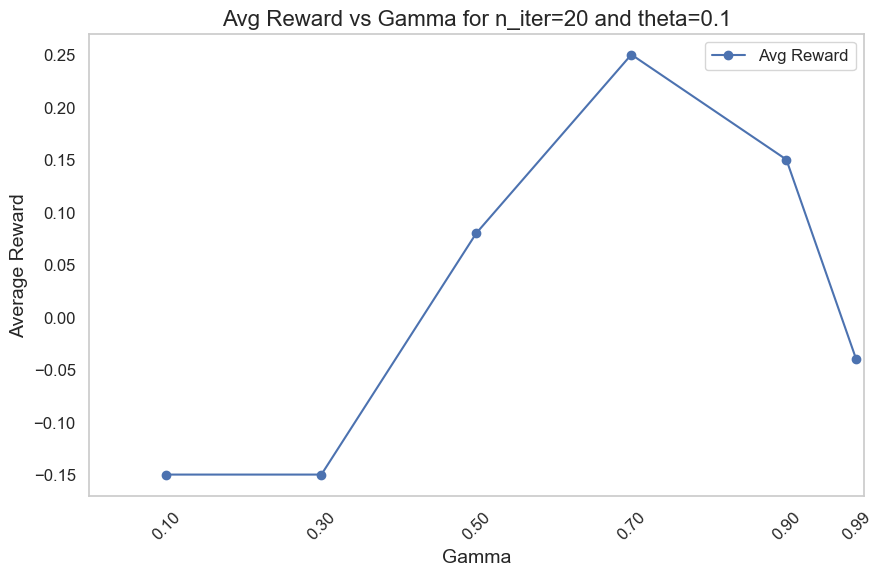

In [47]:
# Filter rows where n_iter is 20, theta is 0.1, and gamma is in the specified list
gammas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
filtered_df = df[(df['n_iter'] == 20) & (df['theta'] == 0.1) & (df['gamma'].isin(gammas))]

# Sort filtered_df by gamma
filtered_df = filtered_df.sort_values(by='gamma')

# Plot avg_reward vs gamma
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['gamma'], filtered_df['avg_reward'], marker='o', linestyle='-', label='Avg Reward')

# Set x-axis ticks and scale
plt.xticks(gammas, rotation=45, fontsize=12)  # Increased tick font size
plt.yticks(fontsize=12)  # Increased y-axis tick font size
plt.xlim(0.0, 1.0)

# Set axis labels with larger font size
plt.xlabel('Gamma', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)

# Set title and grid
plt.title('Avg Reward vs Gamma for n_iter=20 and theta=0.1', fontsize=16)
plt.grid()
plt.legend(fontsize=12)  # Increased legend font size
plt.show()

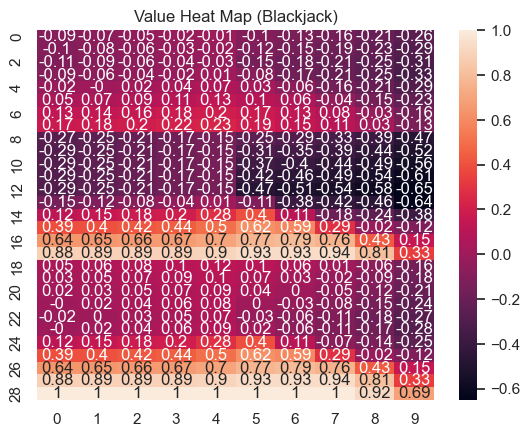

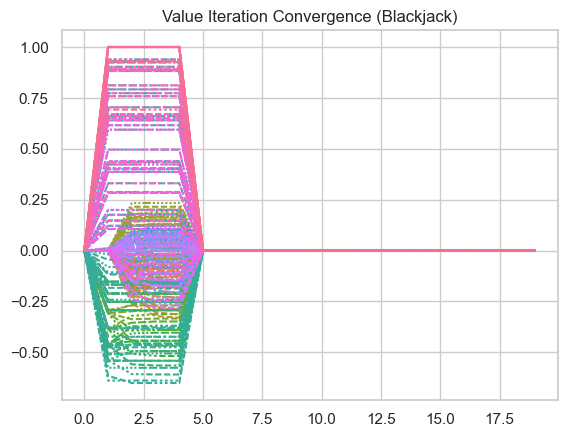

In [123]:
# Set random seed
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Initialize the Blackjack environment with a wrapper
base_env = gym.make('Blackjack-v1', render_mode=None)
base_env.reset(seed=RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)

# Value iteration parameters
gamma = 0.7
n_iter = 20
theta = 0.1

# Run value iteration using the Planner class
V, V_track, pi = Planner(blackjack.P).value_iteration(gamma=gamma, n_iters=n_iter, theta=theta)

# Determine the size dynamically based on the length of V
size = (29,10)

# Generate the heat map with the corrected size
Plots.values_heat_map(data=V, title="Value Heat Map (Blackjack)", size=size)
Plots.v_iters_plot(data=V_track, title="Value Iteration Convergence (Blackjack)")

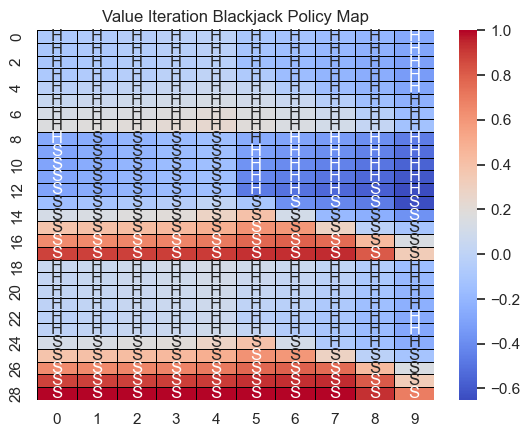

In [ ]:
#create actions dictionary and set map size
blackjack_actions = {0: "S", 1: "H"}
blackjack_map_size=(29, 10)

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi, V, blackjack_actions, blackjack_map_size)

@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

title = "Value Iteration Blackjack Policy Map"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

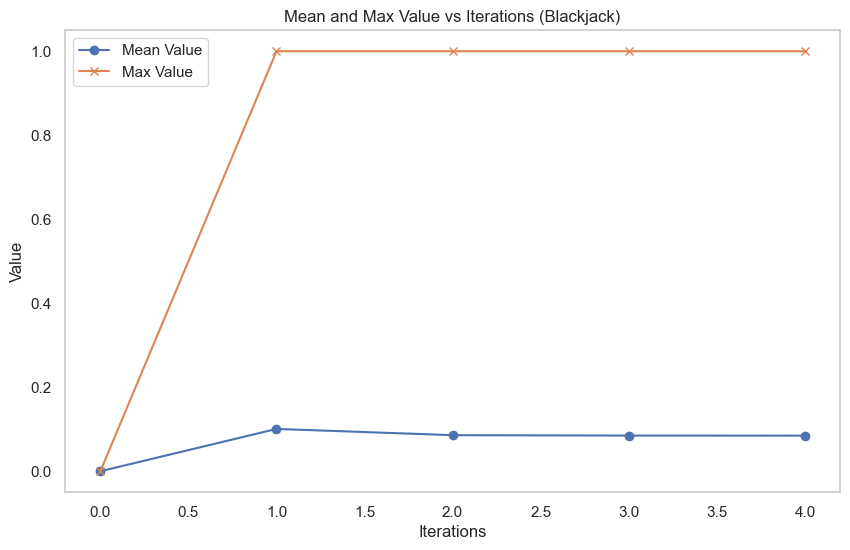

In [ ]:
# Assume V_track is a numpy array of shape (n_iters, n_states)
# Replace this with your actual V_track data
# Each row contains the value function at a specific iteration

# Clip trailing zeros if convergence is reached before max iterations
mean_values_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
max_values_per_iter = np.trim_zeros(np.max(V_track, axis=1), 'b')


# Plot mean and max values over iterations
plt.figure(figsize=(10, 6))
plt.plot(mean_values_per_iter, label="Mean Value", linestyle='-', marker='o')
plt.plot(max_values_per_iter, label="Max Value", linestyle='-', marker='x')

# Add labels, legend, and title
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.title("Mean and Max Value vs Iterations (Blackjack)")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [ ]:
# Test value iteration Blackjack
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)
test_scores = TestEnv.test_env(env=blackjack, n_iters=1000, render=False, pi=pi, user_input=False)
print(test_scores)
print(np.mean(test_scores))

# Average Test Score (Value Iteration, Blackjack): -0.08

[ 0.  1.  1.  0.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1.  0.  1. -1. -1.
 -1.  1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.
  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.
 -1. -1. -1. -1.  0. -1.  0.  1.  1.  0.  0. -1.  1. -1.  1. -1.  1.  1.
 -1.  1. -1. -1. -1.  1. -1. -1.  1.  0.  1.  0. -1. -1.  1. -1.  1.  1.
 -1. -1. -1. -1. -1.  1.  1. -1.  0. -1.  1.  0. -1.  0. -1. -1. -1. -1.
  1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1. -1.  1. -1. -1. -1.  1.
  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  0. -1.  0.
  1.  1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  0.  1.  0.  1.  1. -1.
 -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.
 -1.  0.  0.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  0.  1. -1.
  0.  0. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1.
 -1. -1.  1.  0. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.
 -1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1

# Policy Iteration

In [ ]:
RANDOM_SEED = 50

gammas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
n_iters = [10, 20, 50, 100, 200, 500, 1000]
theta = [0.1, 0.01, 0.001, 0.0001, 0.00001]
base_env = gym.make('Blackjack-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)

rewards_and_params_results_pi, highest_avg_reward_pi, best_params_pi = GridSearch.pi_grid_search(blackjack, gammas, n_iters, theta, verbose=False)
print(highest_avg_reward_pi, best_params_pi)

# Best params for VI
# random seed = 10 -> best_params_pi = {'gamma': 0.7, 'n_iter': 20, 'theta': 0.1}, highest_avg_reward_pi = 0.25
# random seed = 20 -> best_params_vi = {'gamma': 0.94, 'n_iter': 1000, 'theta': 0.0001}, highest_avg_reward_vi = 0.22
# random seed = 30 -> best_params_vi = {'gamma': 0.98, 'n_iter': 10, 'theta': 0.001}, highest_avg_reward_vi = 0.2
# random seed = 40 -> best_params_vi = {'gamma': 0.9, 'n_iter': 20, 'theta': 0.01}, highest_avg_reward_vi = 0.2
# random seed = 50 -> best_params_vi = {'gamma': 0.3, 'n_iter': 200, 'theta': 0.1}, highest_avg_reward_vi = 0.24

0.24 (0.3, 200, 0.1)


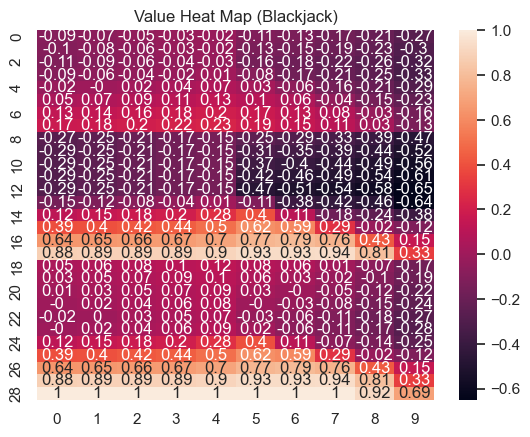

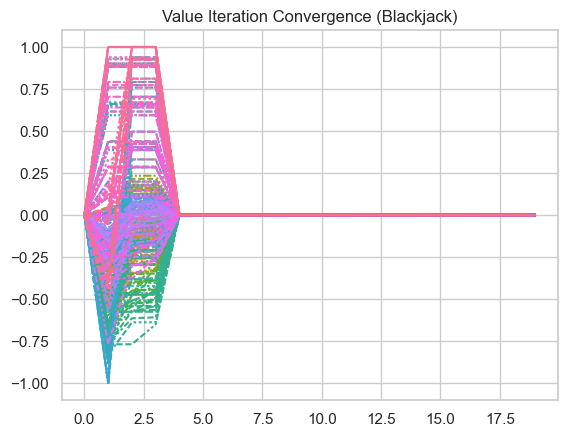

In [124]:
# Set random seed
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Initialize the Blackjack environment with a wrapper
base_env = gym.make('Blackjack-v1', render_mode=None)
base_env.reset(seed=RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)

# Value iteration parameters
gamma = 0.7
n_iter = 20
theta = 0.1

# Run value iteration using the Planner class
V_pi, V_track_pi, pi_pi = Planner(blackjack.P).policy_iteration(gamma=gamma, n_iters=n_iter, theta=theta)

# Determine the size dynamically based on the length of V
size = (29,10)

# Generate the heat map with the corrected size
Plots.values_heat_map(data=V_pi, title="Value Heat Map (Blackjack)", size=size)
Plots.v_iters_plot(data=V_track_pi, title="Value Iteration Convergence (Blackjack)")

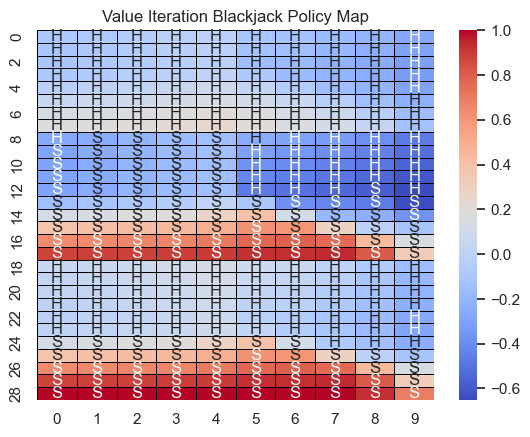

In [80]:
#create actions dictionary and set map size
blackjack_actions = {0: "S", 1: "H"}
blackjack_map_size=(29, 10)

#get formatted state values and policy map
val_max, policy_map = Plots.get_policy_map(pi_pi, V_pi, blackjack_actions, blackjack_map_size)

@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

title = "Value Iteration Blackjack Policy Map"
Plots.modified_plot_policy(val_max, policy_map, blackjack_map_size, title)

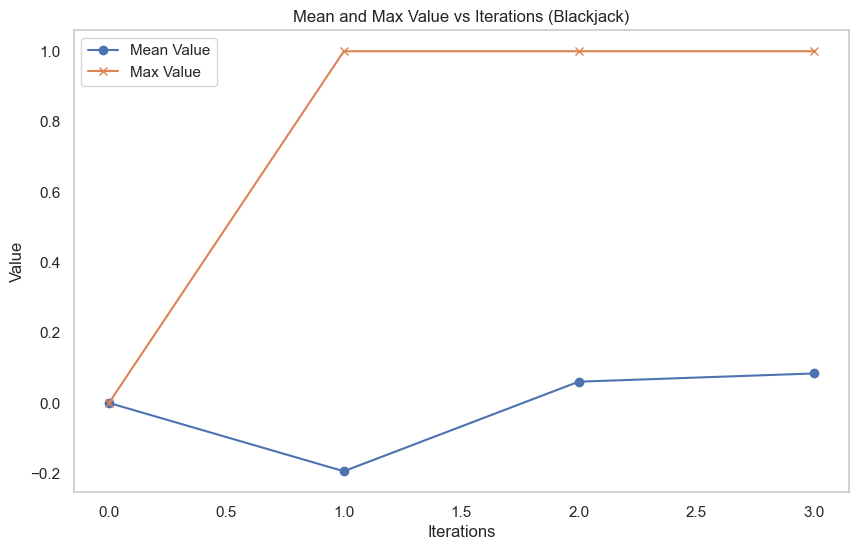

In [81]:
# Assume V_track is a numpy array of shape (n_iters, n_states)
# Replace this with your actual V_track data
# Each row contains the value function at a specific iteration

# Clip trailing zeros if convergence is reached before max iterations
mean_values_per_iter_pi = np.trim_zeros(np.mean(V_track_pi, axis=1), 'b')
max_values_per_iter_pi = np.trim_zeros(np.max(V_track_pi, axis=1), 'b')


# Plot mean and max values over iterations
plt.figure(figsize=(10, 6))
plt.plot(mean_values_per_iter_pi, label="Mean Value", linestyle='-', marker='o')
plt.plot(max_values_per_iter_pi, label="Max Value", linestyle='-', marker='x')

# Add labels, legend, and title
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.title("Mean and Max Value vs Iterations (Blackjack)")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [ ]:
# Test policy iteration Blackjack
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)
test_scores_pi = TestEnv.test_env(env=blackjack, n_iters=1000, render=False, pi=pi_pi, user_input=False)
print(np.mean(test_scores_pi))

-0.08


# Q-Learning

In [ ]:
# Set random seed
RANDOM_SEED = 10

# Define parameters for Q-learning
gammas = [0.1, 0.3, 0.5, 0.7, 0.9,  0.99]
epsilon_decay = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
n_iters = [10000, 50000, 100000]

# Initialize Blackjack environment
base_env = gym.make('Blackjack-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)

# Run Q-learning grid search
rewards_and_params_results_q, highest_avg_reward_q, best_params_q = GridSearch.q_learning_grid_search(
    env=blackjack,
    gamma=gammas,
    epsilon_decay=epsilon_decay,
    iters=n_iters,
    verbose=False
)

# Print the results
print("Highest Average Reward from Q-learning:", highest_avg_reward_q)
print("Best Parameters for Q-learning:", best_params_q)

# Highest Average Reward from Q-learning: 0.13
# Best Parameters for Q-learning: (0.99, 0.3, 100000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Highest Average Reward from Q-learning: 0.13
Best Parameters for Q-learning: (0.99, 0.3, 100000)


In [ ]:
# Convert dictionary to DataFrame
df_q = pd.DataFrame(rewards_and_params_results_q)
df_q[['gamma', 'epsilon_decay', 'iters']] = pd.DataFrame(df_q['params'].tolist(), index=df_q.index)
df_q = df_q.drop(columns=['params'])

# Sort DataFrame in descending order by avg_reward
df_q = df_q.sort_values(by='avg_reward', ascending=False)

# Save DataFrame to a CSV file
file_path = "q-learning_bj_results.csv"
df_q.to_csv(file_path, index=False)

In [ ]:
print(df_q)

     avg_reward  gamma  epsilon_decay   iters
95         0.13   0.99           0.30  100000
52         0.12   0.50           0.99   50000
71         0.11   0.70           0.99  100000
100        0.09   0.99           0.70   50000
1          0.09   0.10           0.10   50000
..          ...    ...            ...     ...
81        -0.24   0.90           0.70   10000
43        -0.27   0.50           0.50   50000
61        -0.28   0.70           0.50   50000
51        -0.28   0.50           0.99   10000
89        -0.37   0.90           0.99  100000

[108 rows x 4 columns]


In [94]:
# Set random seed
RANDOM_SEED = 10

# Initialize Blackjack environment
base_env = gym.make('Blackjack-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)

# Define parameters for Q-learning
gammas = 0.99
epsilon_decay = 0.3
n_iters = 100000

Q, V_Q, pi_Q, Q_track, pi_track_Q = RL(blackjack).q_learning(gamma=gammas, epsilon_decay_ratio=epsilon_decay, n_episodes=n_iters)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
# Test Q-learning Blackjack
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)
test_scores_q = TestEnv.test_env(env=blackjack, n_iters=1000, render=False, pi=pi_Q, user_input=False)
print(np.mean(test_scores_q))

-0.064


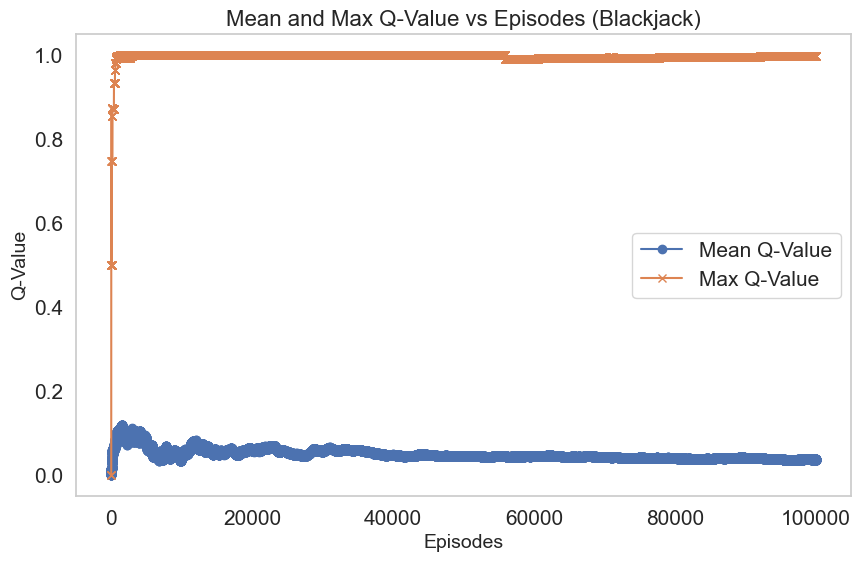

In [105]:
# Calculate the maximum Q-value for each state and each iteration
V_track_Q = np.max(Q_track, axis=2)  # Max Q-value across actions for each state
mean_values_per_iter_Q = np.trim_zeros(np.mean(V_track_Q, axis=1), 'b')  # Mean Q-value across states
max_values_per_iter_Q = np.trim_zeros(np.max(V_track_Q, axis=1), 'b')  # Max Q-value across states

# Plot mean and max Q-values over iterations
plt.figure(figsize=(10, 6))
plt.plot(mean_values_per_iter_Q, label="Mean Q-Value", linestyle='-', marker='o')
plt.plot(max_values_per_iter_Q, label="Max Q-Value", linestyle='-', marker='x')

# Add labels, legend, and title
plt.xlabel("Episodes", fontsize=14)  # Larger x-axis label
plt.ylabel("Q-Value", fontsize=14)  # Larger y-axis label
plt.title("Mean and Max Q-Value vs Episodes (Blackjack)", fontsize=16)

# Adjust tick size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)  # Larger legend text
plt.grid()

# Show plot
plt.show()

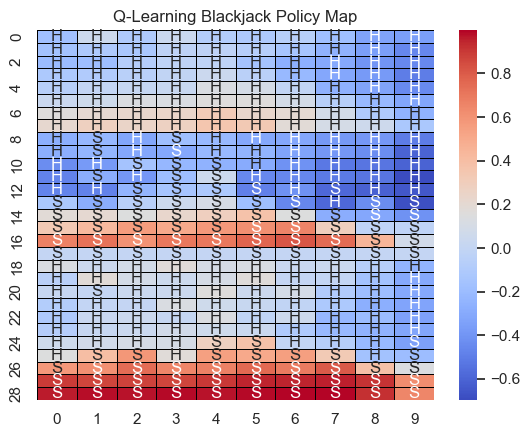

In [108]:
# Create actions dictionary and set map size
blackjack_actions = {0: "S", 1: "H"}  # Stick (S) and Hit (H)
blackjack_map_size = (29, 10)  # Map size based on Blackjack state space: player hands x dealer cards

# Get formatted state values and policy map from Q-learning results
val_max_q, policy_map_q = Plots.get_policy_map(pi_Q, V_Q, blackjack_actions, blackjack_map_size)

@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

# Title for the Q-learning policy map
title_q = "Q-Learning Blackjack Policy Map"
Plots.modified_plot_policy(val_max_q, policy_map_q, blackjack_map_size, title_q)


# SARSA

In [ ]:
# Set random seed
RANDOM_SEED = 10

# Define parameters for SARSA
gammas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
epsilon_decay = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
n_iters = [100000]

# Initialize Blackjack environment
base_env = gym.make('Blackjack-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)

# Run SARSA grid search
rewards_and_params_results_sarsa, highest_avg_reward_sarsa, best_params_sarsa = GridSearch.sarsa_grid_search(
    env=blackjack,
    gamma=gammas,
    epsilon_decay=epsilon_decay,
    iters=n_iters,
    verbose=False
)

# Print the results
print("Highest Average Reward from SARSA:", highest_avg_reward_sarsa)
print("Best Parameters for SARSA:", best_params_sarsa)

# Highest Average Reward from SARSA: 0.18
# Best Parameters for SARSA: (0.9, 0.3, 100000)


Highest Average Reward from SARSA: 0.18
Best Parameters for SARSA: (0.9, 0.3, 100000)


In [ ]:
# Convert to a pandas DataFrame
df_sarsa = pd.DataFrame(rewards_and_params_results_sarsa)
df_sarsa[['gamma', 'epsilon_decay', 'iters']] = pd.DataFrame(df_sarsa['params'].tolist(), index=df_sarsa.index)
df_sarsa.drop(columns=['params'], inplace=True)

# Sort the DataFrame by avg_reward in descending order
df_sarsa = df_sarsa.sort_values(by='avg_reward', ascending=False)

# Save to CSV
csv_filename = "sarsa_bj_results.csv"
df_sarsa.to_csv(csv_filename, index=False)

print(f"Data has been saved to {csv_filename}")

Data has been saved to sarsa_results.csv


In [115]:
# Set random seed
RANDOM_SEED = 10

# Initialize Blackjack environment
base_env = gym.make('Blackjack-v1', render_mode=None)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)

# Define parameters for SARSA
gamma = 0.9
epsilon_decay = 0.3
n_iters = 100000

# Run SARSA
Q_SARSA, V_SARSA, pi_SARSA, Q_track_SARSA, pi_track_SARSA = RL(blackjack).sarsa(
    gamma=gamma,
    epsilon_decay_ratio=epsilon_decay,
    n_episodes=n_iters
)

In [125]:
# Test SARSA Blackjack
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
base_env.action_space.seed(RANDOM_SEED)
base_env.reset(seed=RANDOM_SEED)
blackjack = BlackjackWrapper(base_env)
blackjack.reset(seed=RANDOM_SEED)
test_scores_q = TestEnv.test_env(env=blackjack, n_iters=1000, render=False, pi=pi_SARSA, user_input=False)
print(np.mean(test_scores_q))

-0.099


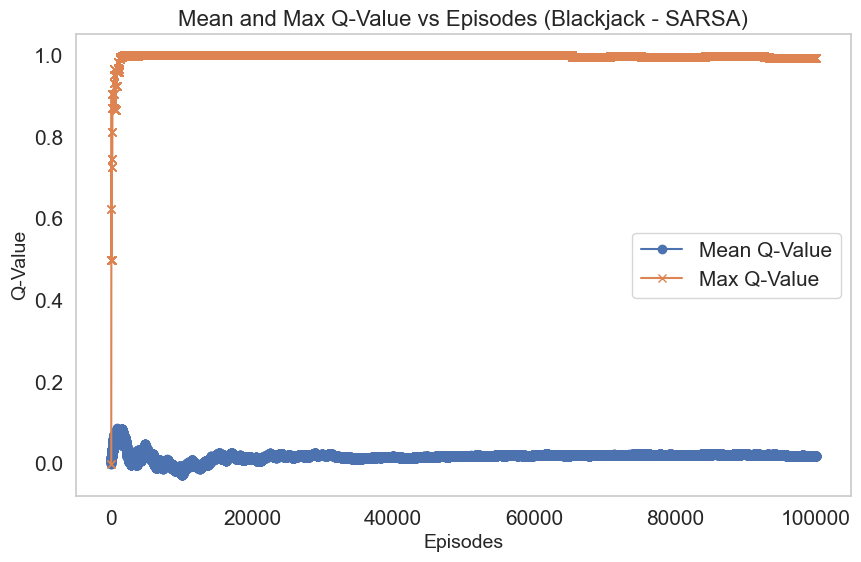

In [126]:
# Calculate the maximum Q-value for each state and each iteration for SARSA
V_track_SARSA = np.max(Q_track_SARSA, axis=2)  # Max Q-value across actions for each state
mean_values_per_iter_SARSA = np.trim_zeros(np.mean(V_track_SARSA, axis=1), 'b')  # Mean Q-value across states
max_values_per_iter_SARSA = np.trim_zeros(np.max(V_track_SARSA, axis=1), 'b')  # Max Q-value across states

# Plot mean and max Q-values over iterations for SARSA
plt.figure(figsize=(10, 6))
plt.plot(mean_values_per_iter_SARSA, label="Mean Q-Value", linestyle='-', marker='o')
plt.plot(max_values_per_iter_SARSA, label="Max Q-Value", linestyle='-', marker='x')

# Add labels, legend, and title
plt.xlabel("Episodes", fontsize=14)  # Larger x-axis label
plt.ylabel("Q-Value", fontsize=14)  # Larger y-axis label
plt.title("Mean and Max Q-Value vs Episodes (Blackjack - SARSA)", fontsize=16)

# Adjust tick size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)  # Larger legend text
plt.grid()

# Show plot
plt.show()

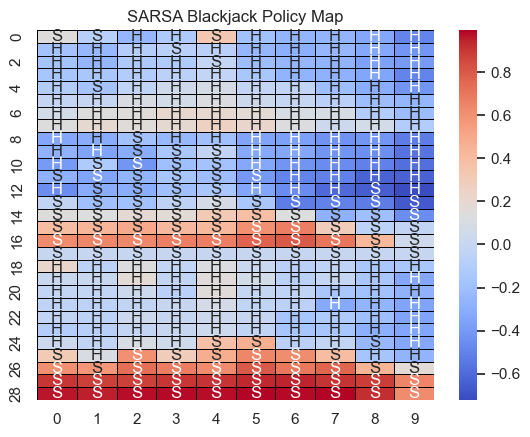

In [127]:
# Create actions dictionary and set map size
blackjack_actions = {0: "S", 1: "H"}  # Stick (S) and Hit (H)
blackjack_map_size = (29, 10)  # Map size based on Blackjack state space: player hands x dealer cards

# Get formatted state values and policy map from SARSA results
val_max_sarsa, policy_map_sarsa = Plots.get_policy_map(pi_SARSA, V_SARSA, blackjack_actions, blackjack_map_size)

@add_to(Plots)
@staticmethod
def modified_plot_policy(val_max, directions, map_size, title):
    """Plot the policy learned."""
    sns.heatmap(
        val_max,
        annot=directions,
        fmt="",
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
    ).set(title=title)
    img_title = f"Policy_{map_size[0]}x{map_size[1]}.png"
    plt.show()

# Title for the SARSA policy map
title_sarsa = "SARSA Blackjack Policy Map"
Plots.modified_plot_policy(val_max_sarsa, policy_map_sarsa, blackjack_map_size, title_sarsa)


In [ ]:
# Average Test Score (Value Iteration, Blackjack): -0.08
# Average Test Score (Policy Iteration, Blackjack): -0.08
# Average Test Score (Q-Learning, Blackjack): -0.064
# Average Test Score (SARSA, Blackjack): -0.099